In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow import keras

from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import visualkeras
import cv2
import os

np.random.seed(42)

# Data Load & Pre-prcessing

In [2]:
X_DATA_PATH = "./data/cropped/"
Y_DATA_PATH = "./data/resized/"

x_data_path_list = os.listdir(X_DATA_PATH)[:32 * 50]
y_data_path_list = os.listdir(Y_DATA_PATH)[:32 * 50]

X, y = list(), list()
for x_data_path in tqdm(x_data_path_list, desc=f'X data loading...'):   X.append(cv2.imread(X_DATA_PATH + x_data_path))
for y_data_path in tqdm(y_data_path_list, desc=f'Y data loading...'):   y.append(cv2.imread(Y_DATA_PATH + y_data_path))

Y data loading...: 100%|██████████| 1000/1000 [00:00<00:00, 2657.80it/s]


In [3]:
y = np.array(y)[:, :, :, 0].reshape(-1, 256, 256, 1)
y = np.array(y) / 255.0

print(f"""Dataset shape : {y.shape}""")

Dataset shape : (1000, 256, 256, 1)


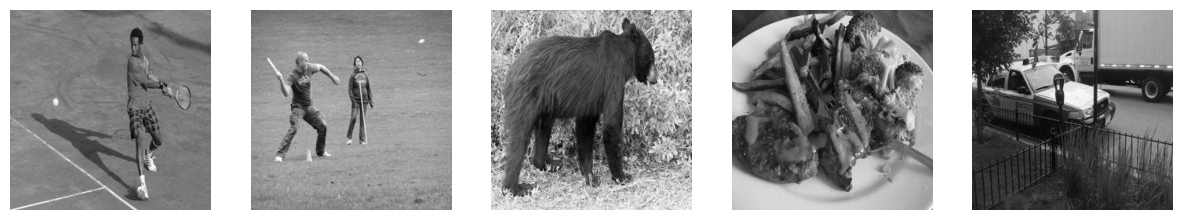

In [4]:
np.random.shuffle(y)
rand_idx = np.random.randint(0, len(y), 5)

fig, ax = plt.subplots(1, 5, figsize=(15, 5))
for i, idx in enumerate(rand_idx):
    ax[i].imshow(y[idx], cmap='gray')
    ax[i].axis('off')
plt.show()

# VAE Model

In [5]:
latent_space = 2

# ResNet BottleNeck Block
def BottleNeck(input_feature, in_channels, out_channels):
    x1 = Conv2D(in_channels, (1, 1), padding='same', activation='relu')(input_feature)
    x1 = layers.BatchNormalization()(x1)
    skip_connection = x1

    x1 = Conv2D(in_channels, (3, 3), padding='same', activation='relu')(x1)
    x1 = layers.BatchNormalization()(x1)

    x1 = Conv2D(out_channels, (1, 1), padding='same', activation='relu')(x1)
    x1 = layers.BatchNormalization()(x1)

    x1 = layers.add([x1, skip_connection])
    x1 = layers.Activation('relu')(x1)

    return x1

# Sampling layer
class Sampling(layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        epsilon = tf.keras.backend.random_normal(shape=tf.shape(mean))
        return mean + tf.exp(0.5 * log_var) * epsilon


In [6]:
# #ncoder
input_img = Input(shape=(256, 256, 1))

x1 = BottleNeck(input_img, 32, 32)

x2 = MaxPooling2D((2, 2), padding='same')(x1)
x2 = BottleNeck(x2, 64, 64)

x3 = MaxPooling2D((2, 2), padding='same')(x2)
x3 = BottleNeck(x3, 128, 128)

x3 = layers.Flatten()(x3)
z_mean = layers.Dense(latent_space, name="z_mean")(x3)
z_log_var = layers.Dense(latent_space, name="z_log_var")(x3)
z = Sampling()([z_mean, z_log_var])

encoder = Model(input_img, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 32)         64        ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv2d_1 (Conv

In [7]:
# Decoder
latent_inputs = keras.Input(shape=(latent_space,), name="z_sampling")
x = layers.Dense(32 * 32 * 128, activation="relu")(latent_inputs)
x = layers.Reshape((32, 32, 128))(x)

x1 = BottleNeck(x, 128, 128)
x2 = UpSampling2D((2, 2))(x1)

x2 = BottleNeck(x2, 64, 64)
x3 = UpSampling2D((2, 2))(x2)

x3 = BottleNeck(x3, 32, 32)
x3 = UpSampling2D((2, 2))(x3)

decoder_outputs = Conv2DTranspose(1, (3, 3), activation="sigmoid", padding="same")(x3)
decoder_outputs = layers.Reshape((256, 256, 1))(decoder_outputs)
decoder = Model(latent_inputs, decoder_outputs, name="decoder")

decoder.summary()

Model: "decoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 z_sampling (InputLayer)     [(None, 2)]                  0         []                            
                                                                                                  
 dense (Dense)               (None, 131072)               393216    ['z_sampling[0][0]']          
                                                                                                  
 reshape (Reshape)           (None, 32, 32, 128)          0         ['dense[0][0]']               
                                                                                                  
 conv2d_9 (Conv2D)           (None, 32, 32, 128)          16512     ['reshape[0][0]']             
                                                                                            

In [8]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [9]:
vae = VAE(encoder, decoder)
vae.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0005)
)

In [10]:
vae.fit(
    y,
    epochs=10,
    batch_size=32,
)

Epoch 1/10
32/32 [==============================] - 49s 1s/step - loss: 262173.4749 - reconstruction_loss: 52743.5859 - kl_loss: 64710.8984
Epoch 2/10
32/32 [==============================] - 44s 1s/step - loss: 43274.0414 - reconstruction_loss: 42302.4453 - kl_loss: 128.2026
Epoch 3/10
32/32 [==============================] - 44s 1s/step - loss: 41038.0709 - reconstruction_loss: 40552.8242 - kl_loss: 124.0003
Epoch 4/10
32/32 [==============================] - 44s 1s/step - loss: 39629.7457 - reconstruction_loss: 39672.7773 - kl_loss: 116.4816
Epoch 5/10
32/32 [==============================] - 47s 1s/step - loss: 39252.3668 - reconstruction_loss: 39112.5508 - kl_loss: 107.1887
Epoch 6/10
32/32 [==============================] - 44s 1s/step - loss: 39128.5498 - reconstruction_loss: 38809.2070 - kl_loss: 101.3633
Epoch 7/10
32/32 [==============================] - 44s 1s/step - loss: 38803.7991 - reconstruction_loss: 38369.5820 - kl_loss: 98.0110
Epoch 8/10
32/32 [=====================

1/1 [==============================] - 0s 25ms/step


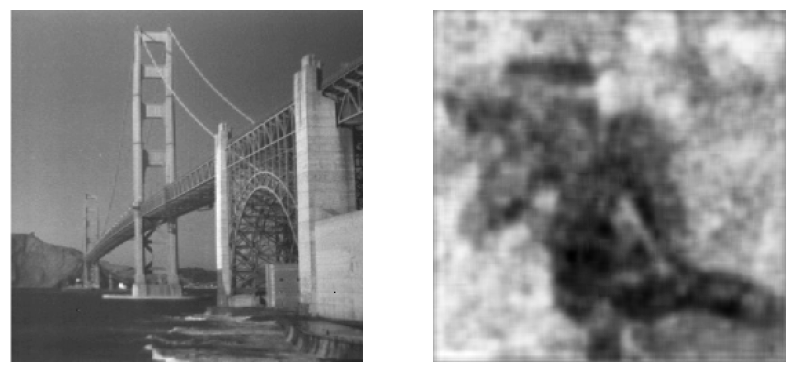

[[  2.5513268 -10.04224  ]] [[-7.068513 -6.886795]] [[  2.5118043 -10.019726 ]]


In [13]:
test_image = cv2.imread('test.png', cv2.IMREAD_GRAYSCALE)
test_image = cv2.resize(test_image, (256, 256))
test_image = test_image.reshape(1, 256, 256, 1)
test_image = np.array(test_image) / 255.0

z_mean, z_log_var, z = encoder.predict(test_image)
reconstruction = decoder.predict(z)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(test_image.reshape(256, 256), cmap='gray')
ax[0].axis('off')
ax[1].imshow(reconstruction.reshape(256, 256), cmap='gray')
ax[1].axis('off')
plt.show()

print(z_mean, z_log_var, z)

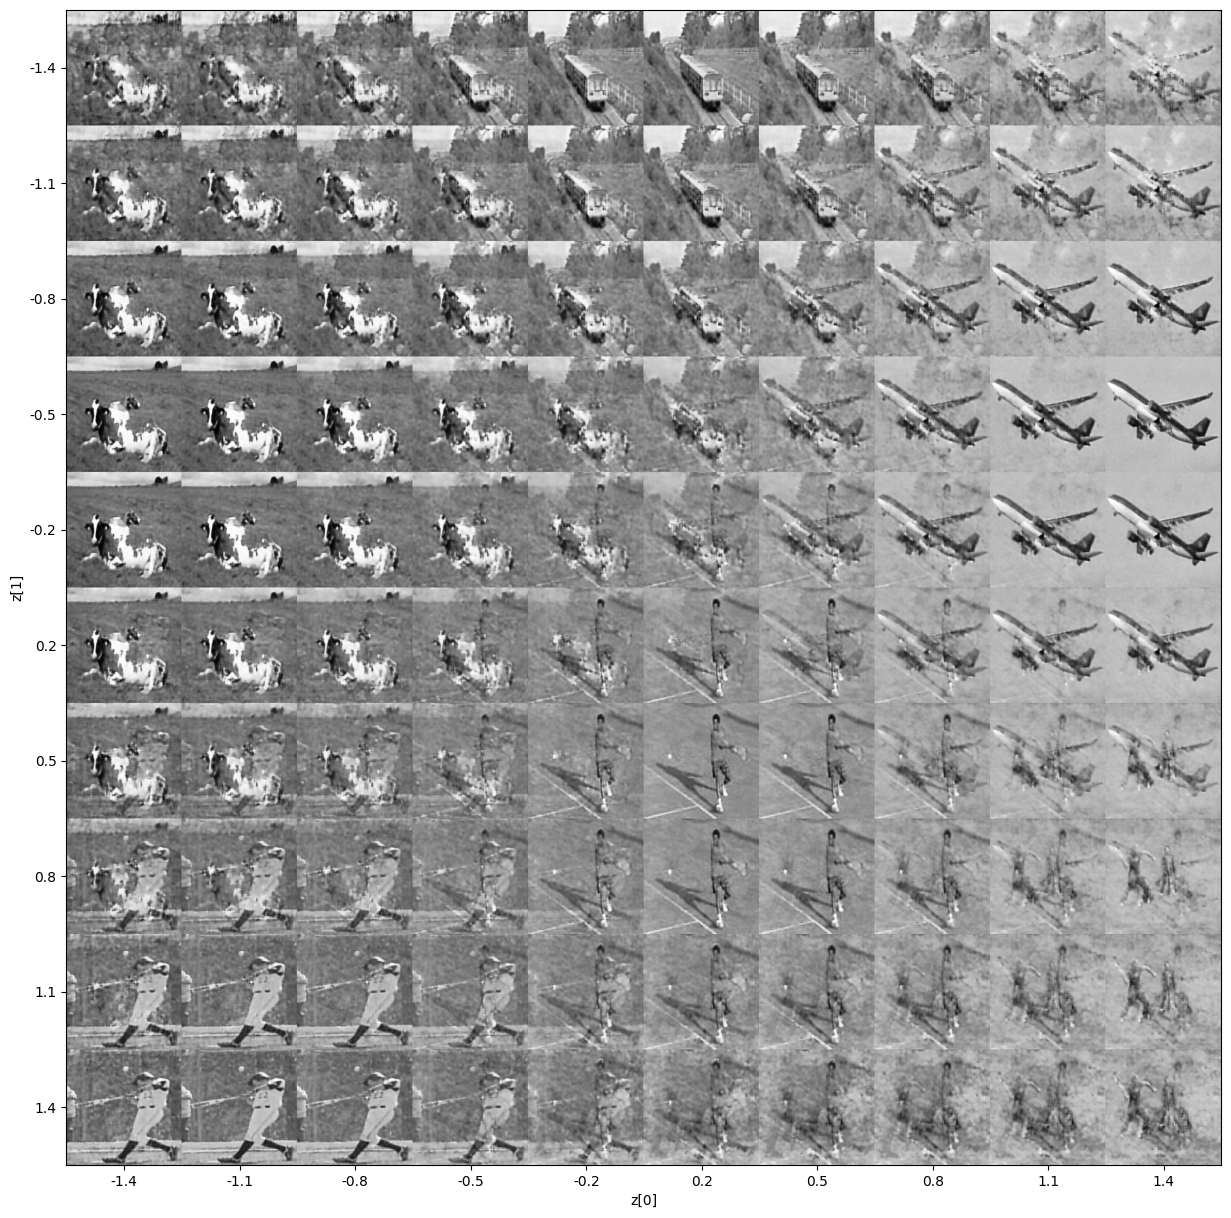

In [19]:
import matplotlib.pyplot as plt


def plot_latent_space(vae, n=10, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 256
    scale = 1.4
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample, verbose=0)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

plot_latent_space(vae)